In [136]:
import re
import random
import pandas as pd
import hashlib

In [137]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [138]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Jane Eyre, Bronte",34.412688,4.301586,7.558390,8
Email Auth and Security,328.565891,41.070736,73.607815,8
Azure Functions + Visual Studio,472.655314,59.081914,92.094704,8
Debugging in VS Code,584.448493,53.131681,99.187559,11
Logging in Python,711.907477,50.850534,123.900687,14
Azure AD Authentication,738.158894,56.781453,136.949262,13
Azure Private DNS,756.012370,39.790125,83.210978,19
RAG Project,883.729067,55.233067,113.572224,16
C# Basics,925.355938,29.850192,51.308047,31
VMWare,981.095263,22.816169,35.584265,43


# Histogram

sum of ages: ~30487.47


<Axes: >

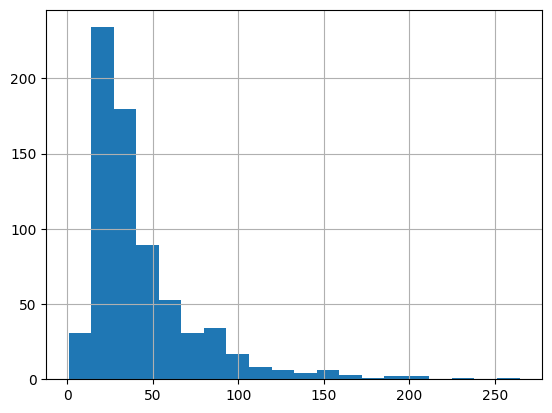

In [139]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [140]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [141]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [142]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [143]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [144]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [145]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [146]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [147]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [148]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 703
Total card age: 30487.47


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
231,Azure Functions + Visual Studio,ASP.NET is a powerful framework for building d...,8d2d2c9f81de88b2156bfde7a7006e30,-92.094704,-59.081914,92.094704,472.655314,0.696049,0,0
232,Azure Functions + Visual Studio,The ASP.NET MVC architecture is based on the M...,3fa44cb97d5bfb30b34e23b072cd1f2d,-67.316463,-59.081914,92.094704,472.655314,0.696049,3,0
233,Azure Functions + Visual Studio,"In all cases, a function is passed an ILogger ...",5ae5eb31b6197f3db7c53a5f42927b10,-31.770804,-59.081914,92.094704,472.655314,0.696049,6,0
217,Azure AD Authentication,"Built-In Roles\nPredefined roles like Owner, C...",07438f0669237f7f9ade8e2be9c0c6e1,-136.949262,-56.781453,136.949262,738.158894,0.161879,0,0
218,Azure AD Authentication,"Role Assignment\nLinks a principal (user, grou...",f445b4bb29b65e4bfdc8ae15101622af,-61.522286,-56.781453,136.949262,738.158894,0.161879,3,0
219,Azure AD Authentication,Service Principal\nA security identity for an ...,a28d9e0df996c0ac0eb889d97e57ec4f,-39.055982,-56.781453,136.949262,738.158894,0.161879,6,0
220,Azure AD Authentication,Managed Identities\nAzure-managed identities u...,2ad76e64637c614682a8f5211278b094,-27.275616,-56.781453,136.949262,738.158894,0.161879,9,0
221,Azure AD Authentication,Azure AD Roles vs Azure Resource Roles\nAzure ...,6c6c1200236d748fc352faaaf8856bff,-17.793243,-56.781453,136.949262,738.158894,0.161879,12,0
148,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-232.421406,-55.677708,232.421406,1169.231875,0.132326,0,0
149,Azure Functions + PP365,Power Platform CLI\nA command-line interface t...,517d71c585ac6a335c1f885c6c7061a0,-75.411140,-55.677708,232.421406,1169.231875,0.132326,3,0


## Age Max

In [149]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [150]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [151]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [152]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
240,Azure Developer Associate,What are the two primary data types collected ...,f0995a4e3eae52ece78cb2f025efcf7f,-264.351219,-44.136031,264.351219,3221.930298,0.024523,0,0
148,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-232.421406,-55.677708,232.421406,1169.231875,0.132326,0,0
54,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-206.717878,-52.217566,206.717878,3133.053985,0.069595,0,0
476,Azure Developer Associate,Which role grants least privilege to allow a u...,72ce544617e81069d717793d0c83d443,-204.888890,-44.136031,264.351219,3221.930298,0.024523,1,1
390,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-192.563156,-55.677708,232.421406,1169.231875,0.132326,1,1
299,PnP PowerShell,System.IO.Stream (System.IO)\nRepresents a seq...,3f146f4a53f3f36ced6256f3cfc16375,-189.687252,-52.217566,206.717878,3133.053985,0.069595,1,1
117,Python,Q:\nWhat are the two essential methods that an...,558bcbe4e40c504fe6e977eb903fb48d,-182.185113,-54.798198,182.185113,1753.542341,0.058056,0,0
88,Asynchronous Python,Lock (Mutex)\nA lock is a synchronization prim...,2218c022e468947a8bbd7ec0626cfe1e,-164.683183,-45.939493,164.683183,2113.216658,0.611708,0,0
241,Azure Developer Associate,How does the Always restart policy differ from...,0858a8d05dbc45117b3d0f1dd538772b,-163.312604,-44.136031,264.351219,3221.930298,0.024523,2,2
74,JavaScript Concepts,Parcel: A zero-configuration bundler that auto...,8853aee1ab1aab7096a1a8e936fedec1,-161.810859,-52.128283,161.810859,2137.259595,0.423676,0,0


In [153]:
existing_cards.head(10).sum()

head                   Azure Functions + Visual StudioAzure Functions...
body                   ASP.NET is a powerful framework for building d...
hash                   8d2d2c9f81de88b2156bfde7a7006e303fa44cb97d5bfb...
age                                                          -781.610906
subject_mean_age                                             -572.508426
subject_highest_age                                          1425.873234
subject_age_sum                                              7447.224161
head_random_roll                                                3.162191
count                                                                 42
n_fold                                                                 0
dtype: object

In [154]:
existing_cards['age'].mean()

-43.367671526983344